In [131]:
import autograd.numpy as np
from autograd import grad
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from autograd import hessian
import cv2
from sklearn.model_selection import train_test_split


In [132]:
class Kernel:
    def __init__(self,name,**kwargs):         
        # define kernel            
        if name == 'polys':
            self.kernel = self.kernel_poly
            
        if name == 'fourier':
            self.kernel = self.kernel_fourier   

        if name == 'gaussian':
            self.kernel = self.kernel_gaussian   
            
        ### set hyperparameters of kernel ###
        # degree of polynomial
        self.D = 2
        if 'degree' in kwargs:
            self.D = kwargs['degree']
            
        self.beta = 0.01
        if 'beta' in kwargs:
            self.beta = kwargs['beta']
            
    # poly kernel
    def kernel_poly(self,x1,x2):    
        H = (1 + np.dot(x1.T,x2))**self.D - 1
        return H.T
    
    # fourier kernel
    def kernel_fourier(self,x1,x2):    
        # loop over both matrices and create fourier kernel
        num_cols1 = x1.shape[1]
        num_cols2 = x2.shape[1]
        H = np.zeros((num_cols1,num_cols2))
        for n in range(num_cols1):
            for m in range(num_cols2):
                val = np.pi*(x1[:,n] - x2[:,m])                
                ind = np.argwhere(val == 0)
                val[ind] += 10**(-10)
                val1 = np.sin((2*self.D + 1)*val)
                val2 = np.sin(val)
                val3 = np.prod(val1/val2,0) - 1
                H[n,m] = val3
        return H.T
    
    # gaussian kernel
    def kernel_gaussian(self,x1,x2):  
        dist = cdist(x1.T, x2.T, metric='euclidean')**2
        H = np.exp(-self.beta*dist)
        return H.T

In [133]:

def load(path, norm=False):
    data = np.loadtxt(path, delimiter=',')
    print(data.shape)
    data = clean(data)
    x = data[:-1, :]
    if norm is True:
        x = normalize(x)
    y = data[-1:,:]
    return x,y

def normalize(x):
    n = len(x)
    for i in range(n):
        mean = np.mean(x[i])
        dev = np.sqrt(np.mean(np.square(x[i]-mean)))
        x[i] = (x[i] - mean) / dev
    return x

def clean(data):
    return data[:,~np.isnan(data).any(axis=0)]  # delete all the coloum which has nan


class SVMMultiClass_Model:
    def __init__(self, x, y, num_class, kernel_name = 'gaussian', **kwargs):       # x: [features, batch]  y: [1, batch]
        self.x = x
        self.y = y
        self.num_class = num_class
        self.kernel = Kernel(kernel_name, **kwargs)
        self.K_train = self.kernel.kernel(self.x,self.x)
        self.w = np.random.random((len(self.K_train)+1,num_class))*2 - 1       # w: [features, class]


        pass
    def linear_model(self, w):
        return np.dot(self.K_train.T, w[1:,:]) + w[0,:]      # [batch, class]

    def linear_model2(self,x,w):                       
        return np.dot(x.T, w[1:]) + w[0]

    def predict_model(self, x):
        return np.dot(self.kernel.kernel(self.x,x).T, self.w[1:,:]) + self.w[0,:]

    def normalize_weight(self, w):
        '''
        nofrmailze the weight for signed distance
        w_normalized = w_origin / sqrt(sum(w_origin^2)) for each class
        '''   
        for c in range(len(w[0])):    # loop class
            sum = np.sqrt(np.sum(np.square(w[:,c])))   # L2 norm
            w[:,c] = w[:,c] / sum
        return w

    def max_distance(self, w):
        max_class = np.argmax(self.linear_model(w), axis = 1)     #[batch] 
        max_dis = np.max(self.linear_model(w), axis = 1)          #[batch]
        return max_class, max_dis

    def perceptron_multiclass(self, w):
        # w = self.normalize_weight(w)
        cost = 0
        max_class, max_dis = self.max_distance(w)
        for i in range(len(self.x[0])):
            cost += max_dis[i] - (np.dot(self.x[:,i], w[1:,int(self.y[0,i])]) + w[0, int(self.y[0,i])])
        cost = cost / len(self.x[0])
        return cost
    
    def softmax_multiclass(self, w):
        cost = 0
        for i in range(len(self.y[0])):
            cost += np.log(np.sum( [np.exp(self.linear_model2(self.K_train[:,i], w[:,j])) for j in range(self.num_class)] )) - self.linear_model2(self.K_train[:,i], w[:,int(self.y[0,i])])
            # cost += np.log(np.sum( [np.exp(np.dot(self.x[:,i].T, w[1:,j]) + w[0,j]) for j in range(self.num_class)] ))
        cost = cost / len(self.y[0])
        return cost

    def GD(self, loss, lr):
        
        grad_fun = grad(loss)
        self.w = self.w - lr*grad_fun(self.w)
            
    def test_misclassification(self):
        misclass = 0
        # w = self.normalize_weight(w)
        max_class, max_dis = self.max_distance(self.w)  #w
        for i,c in enumerate(max_class):
            if c != self.y[0,i]:
                misclass += 1
        return misclass
    
    def test_accuracy(self):
        misclass = self.test_misclassification()
        return (len(self.y[0]) - misclass) / len(self.y[0])

    def predict(self, image):
        max_class = np.argmax(self.predict_model(image), axis = 1)
        return max_class



In [134]:
def train(model, epoch, lr_init, loss_fun, val_fun, lr_mode = 'fix'):
    log = np.array([[loss_fun(model.w), val_fun()]])
    for i in range(epoch):
        if lr_mode == 'diminish':
            lr = lr_init / (i+1)
        elif lr_mode == 'fix':
            lr = lr_init
        
        model.GD(loss_fun, lr)
        # model.newtons_method(loss_fun)
        loss = loss_fun(model.w)
        val = val_fun()
        print('finish epoch: {}, loss: {}, val: {}'.format(i,loss,val))
        log = np.append(log, np.array([[loss, val]]),axis=0)
    return log

In [135]:
def RGBtoGray(data):
    new_data = np.zeros((1, data.shape[1], data.shape[2]))
    for im in data:
        new_data = np.append(new_data, cv2.cvtColor(im.astype('float32'),cv2.COLOR_RGB2GRAY).reshape(1,data.shape[1], data.shape[2]), axis=0)
    return new_data[1:,:,:]

In [136]:
def Flatten(images):
    images = images.reshape(images.shape[0], -1)
    # images = images.reshape(-1, images.shape[0])
    return images

In [137]:
data1 = np.load('../Data/FaceMask_dataset/Pixel20/Correct.npy')
data2 = np.load('../Data/FaceMask_dataset/Pixel20/Incorrect.npy')
data3 = np.load('../Data/FaceMask_dataset/Pixel20/NoMask.npy')
data = np.append(data1, data2, axis=0)
data = np.append(data, data3, axis=0)
x = Flatten(RGBtoGray(data)) / 1000 + 1e-6

In [138]:
labels = [[0]]*data1.shape[0]
labels = np.append(labels, [[1]]*data2.shape[0], axis = 0)
labels = np.append(labels, [[2]]*data3.shape[0], axis = 0)

In [139]:
x_train, x_test , y_train, y_test = train_test_split(x,labels, test_size = 0.8)


In [140]:
x_train = x_train.reshape(x_train.shape[1], -1)
y_train = y_train.reshape(y_train.shape[1], -1)
print(x_train.shape, y_train.shape)


(400, 911) (1, 911)


In [141]:
x_ = x_train[:,:100]
y_ = y_train[:,:100]

In [146]:
model = SVMMultiClass_Model(x_,y_,3, beta=1)
log = train(model, 500, 0.05, model.softmax_multiclass, model.test_misclassification)
print(log[-10:])

finish epoch: 0, loss: 1.723157803266879, val: 58
finish epoch: 1, loss: 1.6741879235893422, val: 59
finish epoch: 2, loss: 1.6291787249368468, val: 59
finish epoch: 3, loss: 1.5880320772856953, val: 59
finish epoch: 4, loss: 1.5506076652878944, val: 59
finish epoch: 5, loss: 1.516729737746528, val: 58
finish epoch: 6, loss: 1.4861948228608801, val: 58
finish epoch: 7, loss: 1.4587797776188929, val: 58
finish epoch: 8, loss: 1.4342496072950703, val: 57
finish epoch: 9, loss: 1.4123646106013772, val: 58
finish epoch: 10, loss: 1.3928865494847409, val: 55
finish epoch: 11, loss: 1.3755836847381664, val: 56
finish epoch: 12, loss: 1.3602346414542228, val: 56
finish epoch: 13, loss: 1.3466311621580456, val: 57
finish epoch: 14, loss: 1.3345798677954093, val: 59
finish epoch: 15, loss: 1.3239031804118144, val: 59
finish epoch: 16, loss: 1.3144395720073738, val: 59
finish epoch: 17, loss: 1.3060432982746866, val: 59
finish epoch: 18, loss: 1.2985837598989953, val: 59
finish epoch: 19, loss: 

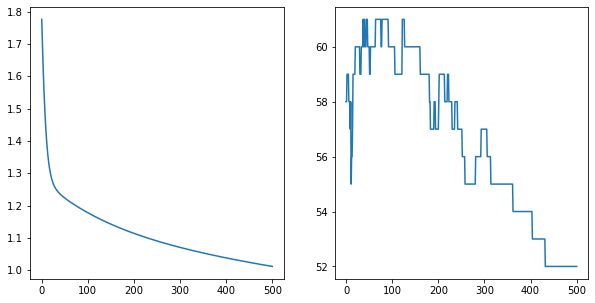

In [148]:
xa = range(len(log))
f,axes = plt.subplots(1,2,figsize=(10,5))
axes[0].plot(xa,log[:,0])
axes[1].plot(xa,log[:,1])